In [351]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from implementations import *

#to access our implemented ML functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
rng = np.random.default_rng(2022)

### We will cut the data into different energy ranges but which ?

In [180]:
data_path = data_file(20.0)

In [181]:
data = clean_df(build_df(data_path))

In [182]:
print(data.shape)

(721043, 18)


In [183]:
data.head()

,index,X(mm),Y(mm),Z(mm),DX,DY,DZ,KinE(MeV),dE(MeV),StepLeng,X(mm)_s,Y(mm)_s,Z(mm)_s,DX_s,DY_s,DZ_s,Kin(MeV)_s,name_s
0,0,0.00,100.0,100.0,0.000,0.000,0.00000,20.0,0.000,0.00,0.00,0.0,0.0,0.000,0.000,0.0000,0.000,0
1,1,4.12,99.8,100.0,0.987,-0.160,-0.01220,18.4,0.563,4.12,4.12,99.8,100.0,0.802,0.592,0.0804,1.070,e-
2,2,8.26,99.1,100.0,0.974,-0.227,-0.01810,17.6,0.621,4.22,8.26,99.1,100.0,0.506,0.811,-0.2930,0.119,e-
3,3,12.90,98.2,100.0,0.983,-0.184,0.00546,16.8,0.779,4.78,0.00,0.0,0.0,0.000,0.000,0.0000,0.000,0
4,4,14.60,97.8,100.0,0.937,-0.331,0.10700,11.6,0.311,1.69,14.60,97.8,100.0,0.987,0.133,-0.0869,4.890,e-


We can add the cosines as we need to predict this parameter

In [184]:
data = get_cos(data)

In [185]:
print(data.shape) #20 000 less than before since we don't have the values of cosine for the last value of each electron

(701043, 19)


Now, we will try different energy ranges and see what fits the most the necessary predictions.

In [186]:
data['E_range'] = 0

In [187]:
data = data[data['index'] != 0]

In [188]:
energy_ranges = [1,5,10,15]
data = map_energy_ranges(data, energy_ranges)

<AxesSubplot:xlabel='StepLeng', ylabel='Count'>

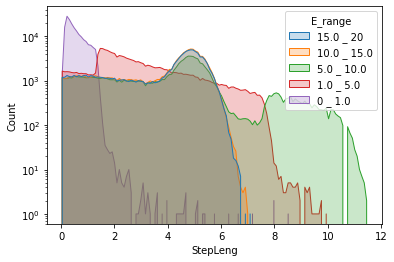

In [189]:
sns.histplot(data, x="StepLeng", hue="E_range", element="poly",log_scale=(False,True))

Here we clearly have the first two energy ranges overlapping and the third others too.
One can distinguish two distributions splitted at E = 7.8 MeV. 

In [190]:
energy_ranges = [7.8, 7.8]
data = map_energy_ranges(data, energy_ranges)

<AxesSubplot:xlabel='StepLeng', ylabel='Count'>

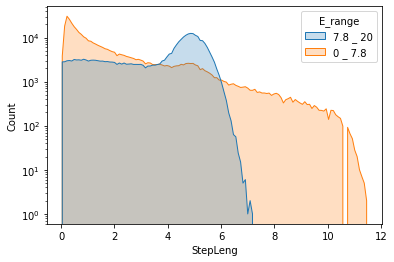

In [191]:
sns.histplot(data, x="StepLeng", hue="E_range", element="poly",log_scale=(False,True))

<AxesSubplot:xlabel='dE(MeV)', ylabel='Count'>

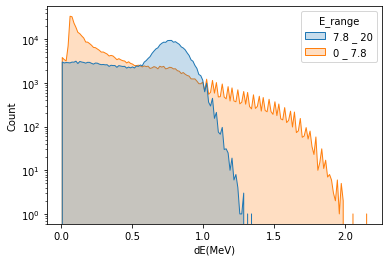

In [192]:
sns.histplot(data, x="dE(MeV)", hue="E_range", element="poly",log_scale=(False,True))

We see that dE and StepLeng are smooth distributions under these energy ranges. We can also study the other parameters

<AxesSubplot:xlabel='cos_theta', ylabel='Count'>

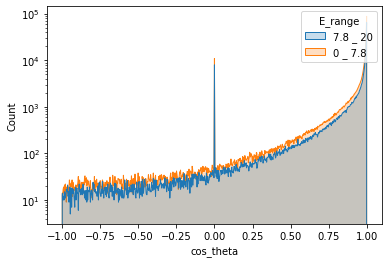

In [193]:
sns.histplot(data, x="cos_theta", hue="E_range", element="poly",log_scale=(False,True))

In [194]:
energy_ranges = [1,5,10,15]
data = map_energy_ranges(data, energy_ranges)

<AxesSubplot:xlabel='cos_theta', ylabel='Count'>

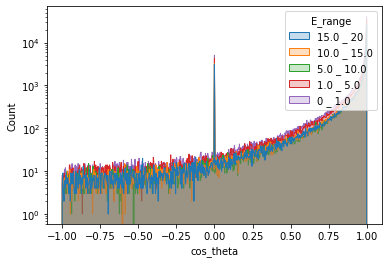

In [195]:
sns.histplot(data, x="cos_theta", hue="E_range", element="poly",log_scale=(False,True))

For cos_theta, the distribution is the same whatever the energy range is.

## Is there energy ranges for emissions ?

In [196]:
data_emission = data.copy(deep = True)

<AxesSubplot:xlabel='KinE(MeV)', ylabel='Density'>

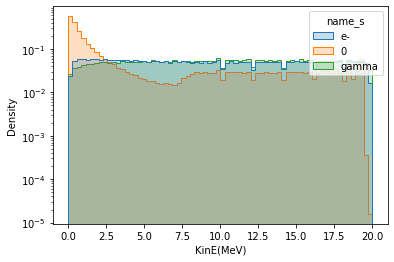

In [206]:
# Creates a normalized density representation of all categories of particle emitted for a given energy
# of the initial electron

sns.histplot(data=data_emission, x="KinE(MeV)", hue="name_s", element='step', log_scale=(False,True),\
             bins=70,stat="density", common_norm=False,)

#### The fact that an initial electron generates a daughter particle depends slightly on the energy of the initial particle. 

Do we need to split the analysis depending on the particle ? The E_range will map every electron into a category range of energy.

In [154]:
data_emission['name_s'] = data_emission['name_s'].apply(type_to_num)

In [155]:
data_0 = data_emission.loc[data_emission['name_s'] == 0]
print(data_0.shape)

(441704, 20)


In [156]:
data_e = data_emission.loc[data_emission['name_s'] == 1]
print(data_e.shape)

(182608, 20)


In [157]:
data_g = data_emission.loc[data_emission['name_s'] == 2]
print(data_g.shape)

(56731, 20)


Text(0.5, 1.0, 'gamma')

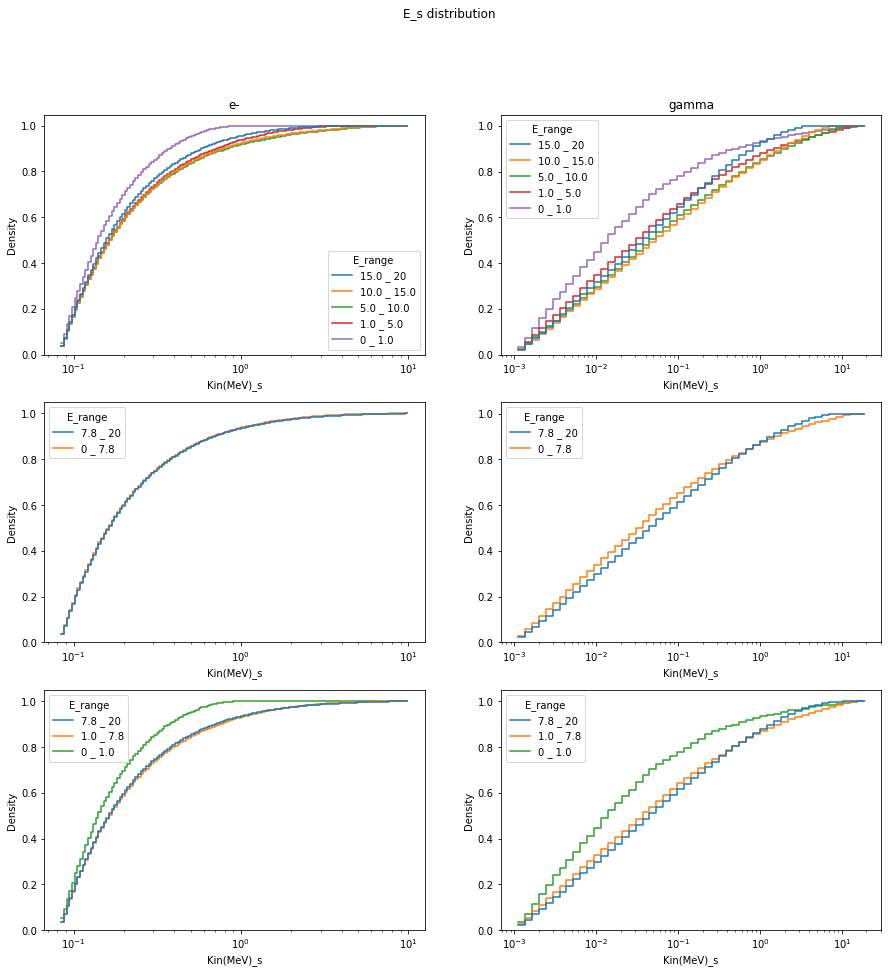

In [170]:
energy_ranges = [1,5,10,15]
data_emission = map_energy_ranges(data_emission, energy_ranges)

data_0 = data_emission.loc[data_emission['name_s'] == 0]
data_e = data_emission.loc[data_emission['name_s'] == 1]
data_g = data_emission.loc[data_emission['name_s'] == 2]


fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=False)
fig.suptitle('E_s distribution')

hue_order = data_emission['E_range'].unique().tolist()

# e-
sns.histplot(
    ax=axes[0,0],
    data=data_e, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# gamma
sns.histplot(
    ax=axes[0,1],
    data=data_g, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# Now we change the possible range of electron

energy_ranges = [7.8]
data_emission = map_energy_ranges(data_emission, energy_ranges)
data_e = data_emission.loc[data_emission['name_s'] == 1]
data_g = data_emission.loc[data_emission['name_s'] == 2]

hue_order = data_emission['E_range'].unique().tolist()

#e- 
sns.histplot(
    ax=axes[1,0],
    data=data_e, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# gamma
sns.histplot(
    ax=axes[1,1],
    data=data_g, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

#We change again the ranges

energy_ranges = [1, 7.8]
data_emission = map_energy_ranges(data_emission, energy_ranges)
data_e = data_emission.loc[data_emission['name_s'] == 1]
data_g = data_emission.loc[data_emission['name_s'] == 2]

hue_order = data_emission['E_range'].unique().tolist()

sns.histplot(
    ax=axes[2,0],
    data=data_e, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# gamma
sns.histplot(
    ax=axes[2,1],
    data=data_g, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

axes[0,0].set_title('e-')
axes[0,1].set_title('gamma')

From this cumulative density plots above, one can conclude that from 0 to 1 MeV for the parent electron, the daughter particle will have lower energies than for Energie ranges from 1 to 20 MeV of the parent. Indeed, the density for low energy range reach higher values (y-axis) for lower values of Kin(MeV)s (x-axis) which corresponds to daughter particle energy. 
From this observation, a good split of energy ranges to predict Kin(MeV)s would be 0-1 MeV and 1-20 MeV but as seen earlier, it is not suited for the other parameters to predict.

### Conclusion of analysis

We will split the dataset onto energy ranges. First, we make a GAN for the electron that do not produce any particle, and a GAN for the electron that produces a particle.

The first GAN will take 2 possible ranges: 0-7.8 MeV and 7.8-20 MeV.

The second GAN will also take 2 possible ranges but different 0-1 MeV and 1-20 MeV.

## 1. Prepare torch tensor for ML processing

In [361]:
#We do not take into account the initial energy of the particle
def first_data(df):
    df = df.copy(deep=True)
    df = df.loc[df['name_s'] == 0]
    df = df[['cos_theta','dE(MeV)','StepLeng']]
    df = df.to_numpy()
    return df

In [362]:
data_path = data_file(20.0)

In [363]:
data = first_data(get_cos(clean_df(build_df(data_path))))

In [364]:
data[:5]

array([[0.987     , 0.        , 0.        ],
       [0.98255922, 0.779     , 4.78      ],
       [0.999542  , 0.701     , 4.75      ],
       [0.945264  , 0.7       , 4.35      ],
       [0.984864  , 0.77      , 5.26      ]])

In [365]:
np.isnan(data).sum()

0

In [366]:
def inf_data_gen(dataset=None, batch_size=None):
    """Python infinite iterator (called python-generator) of samples
    following certain distribution.

    Example Usage:
    data_generator = inf_data_gen(dataset='E_20.0.data', batch_size=64)
    sample = next(data_generator)
    """
    while True:
            data = dataset[np.random.choice(dataset.shape[0],\
                                            size=batch_size, replace=False), :]
            data = data.astype("float32")
            yield data  # torch.from_numpy(data)

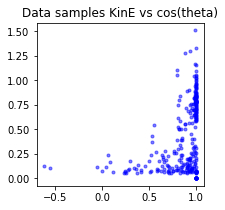

In [367]:
data_generator = inf_data_gen(dataset=data, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker=".", alpha=0.5)
plt.title("Data samples KinE vs cos(theta)")
plt.show()

In [368]:
# @title Setup
# Learning rate of the generator:
g_lr = 1e-4  # @param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 5e-4  # @param {type:"number",  min:0.000001}
# batch size:
batch_size = 64  # @param {type:"integer",  min:1}
# dimension of tha latent vector
noise_dim = 100  # @param {type:"integer",  min:1}
# number of training iterations
total_iterations = 5000  # @param {type:"slider", min:1, max:50000, step:1}

In [369]:
# @title Loss & GAN architecture: define MLPs for th Generator & the Discriminator
import torch.nn as nn

criterion = nn.BCELoss()  # Binary cross entropy


class GeneratorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=3, noise_dim=100):
        super(GeneratorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_out),
        )

    def forward(self, x):
        return self.net(x)


class DiscriminatorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=3):
        super(DiscriminatorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_gen_out = dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

g_model = GeneratorMLP(noise_dim=noise_dim)
d_model = DiscriminatorMLP()
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [370]:
def train_generator(gen, disc, loss=None, batch_size=64, device=torch.device("cpu")):
    """Updates the params of disc['model'] (once).

    :param gen: dictionary with key 'model' [torch.nn.Sequential] and
                'optim' [torch.optim]
    :param disc: dictionary with key 'model' [torch.nn.Sequential]
    :param loss: [torch.nn.<loss>]
    :param batch_size: [int]
    :param device: torch.device('cuda') or torch.device('cpu')
    :return: None
    """
    loss = loss or nn.BCELoss()  # Binary cross entropy
    labels = torch.ones(batch_size, 1, device=device)
    noise = torch.randn(batch_size, gen["model"].noise_dim, device=device)

    gen["model"].zero_grad()
    loss(disc["model"](gen["model"](noise)), labels).backward()
    gen["optim"].step()  # update params of the generator
    return

In [374]:
def train_discriminator(
    gen,
    disc,
    data_sampler,
    n_steps=1,
    loss=None,
    batch_size=64,
    device=torch.device("cpu"),
):
    """Updates the params of disc['model'] n_steps times.

    :param gen: dictionary with key 'model' [torch.nn.Sequential]
    :param disc: dictionary with key 'model' [torch.nn.Sequential] and
                 'optim' [torch.optim]
    :param data_sampler: [python generator (https://wiki.python.org/moin/Generators)]
    :param n_steps: [int]
    :param loss: [torch.nn.<loss>]
    :param batch_size: [int]
    :param device: torch.device('cuda') or torch.device('cpu')
    :return: None
    """
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)
    loss = loss or nn.BCELoss()  # Binary cross entropy

    for _ in range(n_steps):
        disc["model"].zero_grad()
        #  1. Backprop - D on real: maximize log(D(x)) + log(1 - D(G(z)))
        real_samples = torch.tensor(next(data_sampler), device=device)
        loss(disc["model"](real_samples), real_labels).backward()

        #  2. Backprop - D on fake:
        noise = torch.randn(batch_size, gen["model"].noise_dim, device=device)
        loss(disc["model"](gen["model"](noise)), fake_labels).backward()

        #  3. Update the parameters  of the generator
        disc["optim"].step()
    return

In [375]:
import numpy as np, queue, pylab as plt, random, sys, enum, math

In [378]:
# @title train & store fake samples throughout training

if torch.cuda.is_available():
    g_model = g_model.cuda()
    d_model = d_model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
g_optim = torch.optim.Adam(g_model.parameters(), lr=g_lr, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(d_model.parameters(), lr=d_lr, betas=(0.5, 0.999))

generator = {"model": g_model, "optim": g_optim}
discriminator = {"model": d_model, "optim": d_optim}

fixed_noise = torch.randn(300, noise_dim, device=device)
data_generator = inf_data_gen(dataset=data, batch_size=batch_size)

plot_frequency = total_iterations // 100
fake_samples = []
DONE=0
for i in range(total_iterations):
    train_discriminator(
        generator,
        discriminator,
        data_sampler=data_generator,
        loss=criterion,
        batch_size=batch_size,
        device=device,
    )

    train_generator(
        generator, discriminator, loss=criterion, batch_size=batch_size, device=device
    )
    if (i%100 == 0) :
            sys.stdout.write(f"Finished {i:8} out of {total_iterations:8} {(100.0*i)/total_iterations:.2f} %\r"); sys.stdout.flush()

    if i % plot_frequency == 0 or (i + 1) == total_iterations:
        fake_samples.append(generator["model"](fixed_noise).cpu().detach().numpy())

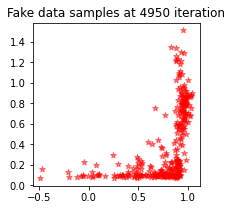

In [395]:
# @title Plot fake samples: select the iteration (0 and 100 are at begining and end of training, resp.)
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}

fake_sample = fake_samples[iteration_plot_generator_samples]
plt.figure(figsize=(3, 3))
plt.scatter(fake_sample[:, 0], fake_sample[:, 1], c="red", marker="*", alpha=0.5)
plt.title(
    f"Fake data samples at {iteration_plot_generator_samples*plot_frequency} iteration"
)
plt.show()

In [396]:
len(fake_sample)

300

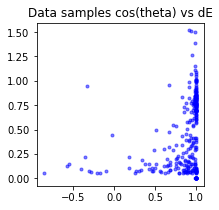

In [397]:
data_generator = inf_data_gen(dataset=data, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker=".", alpha=0.5)
plt.title("Data samples cos(theta) vs dE")
plt.show()